In [706]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt

In [707]:
def score_(X_train, X_valid, y_train, y_valid):
    '''
    Score model with Mean Absolute Error
    '''
    model = LinearRegression(n_jobs=5)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mae(y_valid, preds)

In [708]:
df = pd.read_excel('data/dados.xlsx')
df.head(3)

,address,url,bedrooms,bathrooms,parking,amenities,title,rent,Condomínio,Preço c/ condomínio,IPTU,geocode,suburb,city_district,address_class,postcode,area,type
0,"Avenida Doutor Mário Vilas Boas Rodrigues, 175...",https://www.vivareal.com.br/imovel/apartamento...,2.0,21,1.0,"['Academia', 'Ar-condicionado', 'Churrasqueira...",Apartamento com 2 Quartos e 2 banheiros para...,3900.0,746,4646,225,"Avenida Doutor Mário Vilas Boas Rodrigues, San...",NaN,Santo Amaro,0.0,04757-000,80.0,Aluguel
1,"Rua Fulgêncio Vertello - Cidade Dutra, São Pau...",https://www.vivareal.com.br/imovel/sobrado-1-q...,1.0,1,NaN,[],Sobrado com 1 Quarto e 1 banheiro para Aluga...,900.0,0,0,0,"Rua Fulgêncio Vertello, Cidade Dutra, São Paul...",Cidade Dutra,NaN,0.0,04823-280,40.0,Aluguel
2,"Mirandópolis, São Paulo - SP",https://www.vivareal.com.br/imovel/apartamento...,1.0,1,1.0,"['Academia', 'Churrasqueira', 'Piscina']",Apartamento com 1 Quarto e 1 banheiro para A...,2500.0,726,3226,0,"Mirandópolis, Região Imediata de Andradina, Re...",NaN,NaN,0.0,16800-000,38.0,Aluguel


In [709]:
df.groupby([''])

KeyError: ''

In [710]:
# def get_area_type(row):
#     _v = df2[df2.url == row.url]
#     return _v.loc[_v.index[0], ['area', 'type']]

In [711]:
df['ID'] = df.url.map(lambda x : x.rsplit('-')[-1].replace('/', ''))

In [712]:
#removendo colunas desnecessárias
df.drop(columns=['address', 'amenities', 'title', 'address_class', 'url', 'geocode'], inplace=True)

Quais são os dados nulos?

In [713]:
df.isna().sum().sort_values()

bathrooms                 0
Condomínio                0
Preço c/ condomínio       0
IPTU                      0
type                      0
ID                        0
postcode                188
rent                    260
area                    260
bedrooms                324
suburb                  407
parking                 607
city_district          1031
dtype: int64

In [714]:
def trata_bairro(row):
    '''
    Função para retornar o campo bairro.
    '''
    if pd.isna(row['suburb']) and pd.isna(row['city_district']):
        return np.nan
    if not pd.isna(row['suburb']):
        return row['suburb']
    elif not pd.isna(row['city_district']):
        return row['city_district']
    return 'Analisar'
#     elif row['suburb'] == row['city_district']:
#         return row['city_district']
#     else: 
#         return 'Diferente'

In [715]:
df['bairro'] = df.apply(trata_bairro, axis=1)

Quais os registros sem bairro?

In [716]:
df[df.bairro == 'Analisar']

,bedrooms,bathrooms,parking,rent,Condomínio,Preço c/ condomínio,IPTU,suburb,city_district,postcode,area,type,ID,bairro


In [717]:
df.bairro.isna().sum()

323

Vamos remover os registros que não tenham valores na coluna bairro

In [718]:
df.dropna(subset=['bairro'], inplace=True)

Não precisamos mais das colunas `suburb` e `city_district` e `postcode` (talvez retornemos com o postcode)

In [719]:
df.drop(columns=['suburb', 'city_district', 'postcode'], inplace=True)

O Valor do `aluguel` + `Condomínio` é examtanet o valor do proço total? Sim!!

In [720]:
df=df.drop(columns=['Preço c/ condomínio','IPTU','Condomínio']).rename({
    'bedrooms':'Quartos',
    'bathrooms':'Banheiros',
    'rent':'Preco',
    'bairro':'Bairro',
    'parking': 'Estacionamento'
}, axis=1) #[~((df['rent'].astype(int) + df['Condomínio'].astype(int)) == df['Preço c/ condomínio'].astype(int))]

In [721]:
df.Quartos = df.Quartos.fillna(0).astype(int)

In [722]:
df.Estacionamento = df.Estacionamento.fillna(0)

Valores nulos?

In [723]:
df.isna().sum()

Quartos           0
Banheiros         0
Estacionamento    0
Preco             0
area              0
type              0
ID                0
Bairro            0
dtype: int64

In [724]:
df.reset_index(drop=True, inplace=True)

In [725]:
df.type = df.type.str.strip()

In [726]:
df[df.type == 'Aluguel'].Preco.mean()

33409.75475923852

In [727]:
df[df.type == 'Aluguel'].Preco.median()

2500.0

In [728]:
df.groupby(['type'], as_index=False).ID.count()

,type,ID
0,Aluguel,893
1,Compra,214
2,Não informado,396


In [729]:
df = df[df.type == 'Aluguel']

Removendo os outliers

In [730]:
df= df[df.Preco < 50000].reset_index(drop=True)#.sort_values(by=['Preco'], ascending=False)
df = df[df.Quartos < 6]

In [736]:
df.groupby(['Bairro'], as_index=False).Preco.median().sort_values(by='Preco', ascending=False)

,Bairro,Preco
42,Ermelino Matarazzo,35000.0
56,Jardim Aurélia,20000.0
53,Jardim Aclimação,20000.0
82,Jardins Rio Preto,15000.0
95,Pacaembu,13000.0
...,...,...
73,Jardim Santo André,900.0
69,Jardim Previdência,875.0
126,São João Climaco,850.0
84,Jaçanã,800.0


Vamos pegar uma amostra de valores aleatórios no dataframe.

In [638]:
test_sample = df.sample(10)
df = df.drop(test_sample.index).reset_index(drop=True)

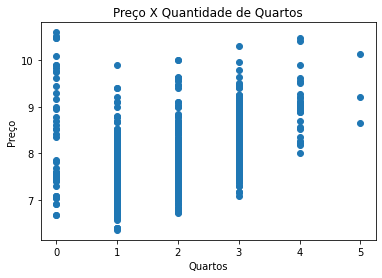

In [639]:
fig, ax= plt.subplots()
ax.scatter(x=df['Quartos'], y=np.log(df['Preco']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


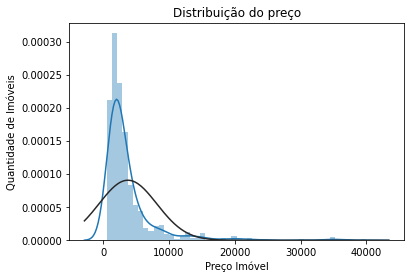

In [640]:
sns.distplot(df.Preco, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


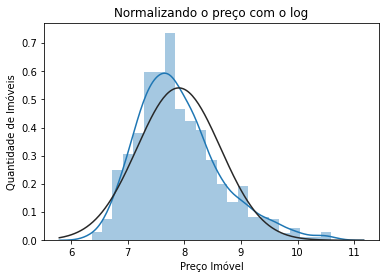

In [641]:
sns.distplot(np.log(df.Preco), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

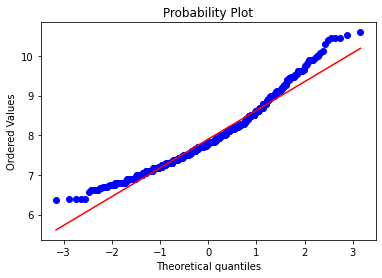

In [642]:
probplot(np.log(df.Preco), plot=plt)
plt.show()

In [643]:
df.Preco = np.log(df.Preco)

In [644]:
df.Bairro = df.Bairro.astype("category")

In [645]:
X = df.drop(columns=['Preco', 'type', 'ID'])
y = df['Preco']

In [673]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Vamos criar uma cópia para evitar alterações
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

label_X_train[['Bairro']] = ordinal_encoder.fit_transform(X_train[['Bairro']].values)
label_X_test[['Bairro']] = ordinal_encoder.transform(X_test[['Bairro']].values)

print("Mean Absolute Error com OrdinalEnconder:") 
print(score_(label_X_train, label_X_test, y_train, y_test))

Mean Absolute Error com OrdinalEnconder:
0.3920326466450002


In [647]:
scores = cross_val_score(LinearRegression(fit_intercept=False, n_jobs=1, positive=True), label_X_train, y_train, cv=5)
scores

array([ -8.97696085, -11.43598   , -14.94605206, -15.74751737,
       -11.50633776])

In [648]:

n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', LinearRegression(n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.39351043, 0.35506377, 0.39874117, 0.36980942, 0.36671045])

In [649]:
# clf = GridSearchCV(LinearRegression(), {'positive': [True, False],'fit_intercept':[True, False], 'n_jobs': [1,3,5,7,10,15,20,30,40,60,100]})
# clf.fit(label_X_train, y_train)
# clf.cv_results_.keys()

In [650]:
# clf.best_estimator_

In [651]:
# clf = GridSearchCV(RandomForestRegressor(), {'n_estimators': [0, 5, 10, 50, 100], 
# #                                        'criterion': ["squared_error", "absolute_error", "poisson"],
#                                        'max_depth': [0, 4, 7, 10],
# #                                        'min_samples_split': [0, 1, 2],
# #                                        'min_samples_leaf': [0, 2, 4],
# #                                        'bootstrap': [True, False],
#                                        'n_jobs': [0, 5, 10],
#                                       'max_samples':[0.0, 0.4, 0.6]})
# clf.fit(label_X_train, y_train)

In [653]:
# clf.best_estimator_

### Quais os melhores hiperparametros?

`RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5)`

In [654]:
n_estimators = 5
pipe = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ("normalizacao", StandardScaler()),
    ('model', RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.32900896, 0.29968631, 0.33132199, 0.33080728, 0.32392836])

In [655]:
pipe.fit(label_X_test.values, y_test)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('normalizacao', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, max_samples=0.4,
                                       n_jobs=5))])

In [656]:
pipe.score(label_X_test.values, y_test)

0.8221941997717528

### PCA

In [657]:
sc = StandardScaler()
sc.fit(label_X_test)
df_standard = sc.transform(label_X_test)
pca = PCA(n_components=5)
pca.fit(df_standard)
np.round(pca.explained_variance_ratio_.cumsum(), decimals=2)

array([0.41, 0.64, 0.84, 0.93, 1.  ])

In [658]:
np.round(pca.explained_variance_ratio_, decimals=2)

array([0.41, 0.23, 0.2 , 0.09, 0.07])

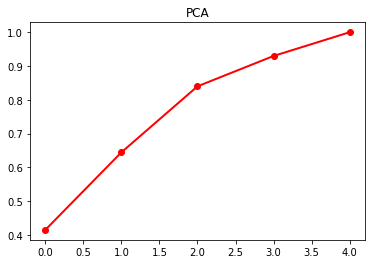

In [659]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('PCA')
plt.show()

Como temos poucas colunas, vamos manter as 5 colunas inicias

In [660]:
from joblib import dump, load

In [678]:
dump(pipe, 'models\pipe_rfr.joblib')
dump(ordinal_encoder, 'models\ordinal_encoder.joblib')

['models\\ordinal_encoder.joblib']

In [679]:
ordinal_encoder = load('models\ordinal_encoder.joblib')

In [663]:
df.groupby(['Bairro'], as_index=False).ID.count().sort_values(by='ID', ascending=False).head(20)

,Bairro,ID
67,Jardim Paulista,53
48,Itaim Bibi,50
91,Moema,44
12,Bela Vista,35
107,Pinheiros,31
50,Jabaquara,24
116,Santo Amaro,24
19,Campo Belo,21
96,Paraíso,19
92,Mooca,17


In [664]:
test_bairro = test_sample['Bairro']

In [665]:
test_sample[['Bairro']] = ordinal_encoder.fit_transform(test_sample[['Bairro']])

In [666]:
test_sample_true = test_sample['Preco']

In [667]:
test_sample.drop(columns=['Preco', 'type', 'ID'],  inplace=True)

In [668]:
np.array([["Santana"],['Vila Santo Estéfano'],
       ['Moema'],
       ['Campo Belo']], dtype='O').reshape(-1, 1)

array([['Santana'],
       ['Vila Santo Estéfano'],
       ['Moema'],
       ['Campo Belo']], dtype=object)

In [734]:
ordinal_encoder.transform([['Pinheiros']])

array([[88.]])

In [698]:
a.flatten()[0]

88.0

In [681]:
np.array(test_bairro)#.reshape(-1, 1)

array(['Vila Sônia', 'Pinheiros', 'Itaim Bibi', 'Parada Inglesa',
       'Vila Buarque', 'Campo Belo', 'Tatuapé', 'Santo Amaro',
       'Vila Sônia', 'Alto da Lapa'], dtype=object)

In [682]:
ordinal_encoder.transform(np.array(test_bairro).reshape(-1, 1))

array([[146.],
       [ 88.],
       [ 42.],
       [ 80.],
       [115.],
       [ 15.],
       [109.],
       [ 96.],
       [146.],
       [ -1.]])

In [470]:
test_sample

,Quartos,Banheiros,Estacionamento,area,Bairro
0,3,2,1.0,75.0,8.0
1,1,1,1.0,35.0,2.0
2,4,44,4.0,307.0,0.0
3,2,1,1.0,58.0,5.0
4,1,1,0.0,45.0,6.0
5,3,31,2.0,180.0,4.0
6,1,1,1.0,35.0,9.0
7,1,1,0.0,16.0,1.0
8,1,11,1.0,35.0,7.0
9,2,1,1.0,65.0,3.0


In [456]:
test_sample = test_sample.reset_index(drop=True)

In [457]:
test_sample.iloc[0].T

Quartos            3.0
Banheiros          2.0
Estacionamento     1.0
area              75.0
Bairro             8.0
Name: 0, dtype: float64

In [458]:
test_sample.iloc[0].to_frame().T

,Quartos,Banheiros,Estacionamento,area,Bairro
0,3.0,2.0,1.0,75.0,8.0


In [459]:
ta = test_sample.iloc[0].to_frame().T

In [460]:
test_sample

,Quartos,Banheiros,Estacionamento,area,Bairro
0,3,2,1.0,75.0,8.0
1,1,1,1.0,35.0,2.0
2,4,44,4.0,307.0,0.0
3,2,1,1.0,58.0,5.0
4,1,1,0.0,45.0,6.0
5,3,31,2.0,180.0,4.0
6,1,1,1.0,35.0,9.0
7,1,1,0.0,16.0,1.0
8,1,11,1.0,35.0,7.0
9,2,1,1.0,65.0,3.0


In [461]:
ta.iloc[0].T

Quartos            3.0
Banheiros          2.0
Estacionamento     1.0
area              75.0
Bairro             8.0
Name: 0, dtype: float64

In [462]:
np.array([2.,1.,1.,51.,6.]).reshape((1,-1))

array([[ 2.,  1.,  1., 51.,  6.]])

In [703]:
pipe.predict(np.array([2.,1.,1.,51.,6.]).reshape(1,-1))

array([7.49976946])

In [705]:
test_bairro

708        Vila Sônia
419         Pinheiros
38         Itaim Bibi
545    Parada Inglesa
95       Vila Buarque
576        Campo Belo
804           Tatuapé
827       Santo Amaro
653        Vila Sônia
34       Alto da Lapa
Name: Bairro, dtype: object

In [704]:
test_sample

,Quartos,Banheiros,Estacionamento,area,Bairro
708,2,21,1.0,77.0,8.0
419,2,52,2.0,148.0,4.0
38,1,11,1.0,50.0,2.0
545,2,21,1.0,48.0,3.0
95,1,1,0.0,75.0,7.0
576,2,2,1.0,70.0,1.0
804,3,21,2.0,70.0,6.0
827,2,31,2.0,120.0,5.0
653,2,11,0.0,55.0,8.0
34,3,31,2.0,120.0,0.0


In [464]:
pipe.predict(test_sample)

c:\python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


array([7.53659253, 7.36390361, 9.40247486, 7.49923603, 7.25296088,
       8.64033929, 7.53602891, 7.04686812, 7.83316122, 7.41092365])

In [465]:
test_sample_true

795     1300.0
48      2200.0
44     33000.0
262     1800.0
615      900.0
830     3500.0
626     1400.0
300     1150.0
716     3700.0
487     2100.0
Name: Preco, dtype: float64

In [467]:
pipe.score(test_sample.values, np.log(test_sample_true))

0.792093933998071

In [324]:
test_sample

,Quartos,Banheiros,Estacionamento,area,Bairro
683,2,1,1.0,51.0,6.0
875,0,0,0.0,870.0,4.0
259,2,21,2.0,87.0,8.0
725,1,1,1.0,40.0,3.0
622,2,1,0.0,65.0,9.0
617,1,21,1.0,51.0,5.0
527,2,21,1.0,56.0,0.0
289,3,43,3.0,134.0,2.0
717,1,1,0.0,26.0,7.0
21,2,21,1.0,57.0,1.0
